# Aprendizaje Automático

## Práctica 9: Algoritmo K-means

En esta práctica vamos a estudiar el algoritmo K-means para clustering. Realizaremos la implementación del mismo paso por paso y terminaremos comparando diferentes particiones obtenidas con K-means mediante el índice de validez de Davies-Bouldin.


## Índice de la práctica

- [Lectura y visualización de datos](#lectura)
- [Implementación del algoritmo K-means](#kmeans)
- [Índices de validez y mejor valor de k](#indices_validez)
- [Estudio para diferentes problemas](#Estudio-para-diferentes-problemas)
- [K-means en scikit](#sklearn)
- [Parte opcional](#opcional)
    - [Clustering jerárquico en Python [Opcional]](#clustering_jerarquico)
- [Comparativa con K-means en scikit [Opcional]](#sklearn_opcional)
- [Otros datos [Opcional]](#otros_datos)

Importamos todas las librerías que vamos a utilizar inicialmente. Posteriormente iremos importando las librerías específicas de cada apartado de la práctica.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from matplotlib.colors import ListedColormap


# Helper function to test the correctness of the solutions
def test_nb(var, val, msg=""):
    if var == val:
        print("✔️ Test passed.")
    else:
        print("❌ Test failed. " + msg)
        raise AssertionError(msg)


%matplotlib inline

## Lectura y visualización de datos <a id="lectura"></a>

Utiliza la función `loadtxt` de numpy para cargar los datos disponibles en el fichero `ex3K.tx` que está dentro de la carpeta `datasets`.

In [18]:
# Cargar la matriz de datos X
X = np.loadtxt('datasets/ex3K.txt',delimiter=',')

# Mostrar las dimensiones (n) y el numero de ejemplos (m)
m, n = X.shape
print("El numero de ejemplos y su dimension es {}x{}".format(m, n))

El numero de ejemplos y su dimension es 198x2


In [19]:
test_nb(m, 198, 'Número de ejemplos incorrecto')
test_nb(n, 2, 'Número de dimensiones incorrecto')

✔️ Test passed.
✔️ Test passed.


Ahora completa la función mostrar para que muestre los ejemplos leídos. En caso de recibir un vector $c$ con los índices de los clústers a los que pertenecen los ejemplos, los ejemplos de cada clúster deberán pintarse de un color.

In [14]:
def mostrar(X, c=None, centroids=None, ax=None):
    """
    Esta función muestra los ejemplos de un problema de clustering
    En caso de estar asignados a un clúster, muestra los ejemplos de cada clúster de un color
    Para ello, c deberá tener el índice del clúster al que pertenece cada ejemplo
    Dibujaremos también los centroides si vienen como entrada
    :param X: Matriz con los ejemplos a mostrar
    :param c: Índices de los clústers a los que pertenece cada ejemplo
    :param centroids: Centroides de los clústers
    :return: Nada
    """
    # Creamos los mapas de colores a utilizar
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#FFFF00', '#0000FF'])

    if ax is None:
        # Creamos la figura
        fig, ax = plt.subplots(figsize=(8, 6))

    # Pintamos los puntos (utiliza como color el vector c, es decir, c = c y recuerda usar el ColorMap definido
    ax.scatter(X[:,0],X[:,1],c=c, cmap=cmap_bold)
    # Pintamos los centroides si los hay 
    if centroids is not None:
        ax.scatter(centroids[:,0], centroids[:,1], marker='*', c=range(centroids.shape[0]), 
                   cmap=cmap_bold, s=500, edgecolors='black', linewidths=2)

    # Nombramos los ejes
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    return

Muestra los ejemplos leídos haciendo uso de la función anterior.

/var/folders/x1/zlr91hyj1kb9jx7yvlg1rcn80000gn/T/ipykernel_41836/3308229349.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[:,0],X[:,1],c=c, cmap=cmap_bold)


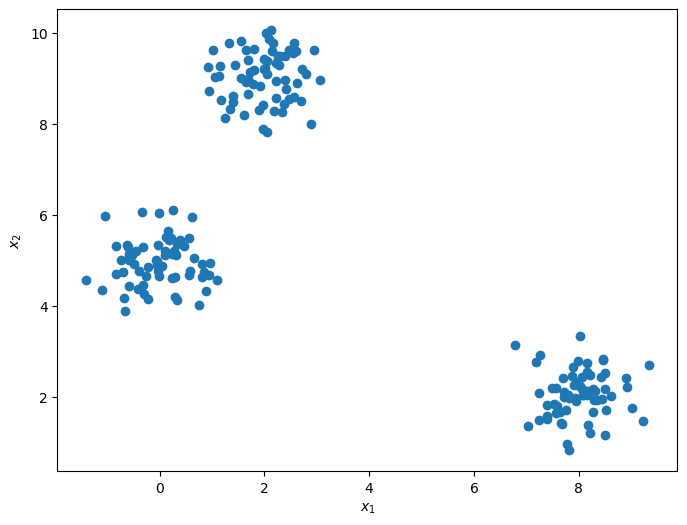

In [20]:
mostrar(X)

## Implementación del algoritmo K-means <a id="kmeans"></a>


Vamos a realizar la implementación del algoritmo k-means por partes.

Primero vamos a inicializar todas las variables que necesitamos.
- `k` va a ser el número de clústeres que queremos utilizar (lo pondremos al número de clústeres que esperamos encontrar en el ejemplo de la figura)
- `centroids` va a ser un vector en el que estarán los centroides iniciales, por lo tanto tiene que ser de dimensión $k\times n$. Como centroides, seleccionaremos inicialmente $k$ ejemplos de manera aleatoria del conjunto de datos.
- `c` es un vector en el que almacenaremos el índice del clúster al que está asignado cada elemento. Lo inicializaremos a ceros.

Finalmente, utiliza la función mostrar para ver los puntos y los centroides inicializados aleatoriamente.

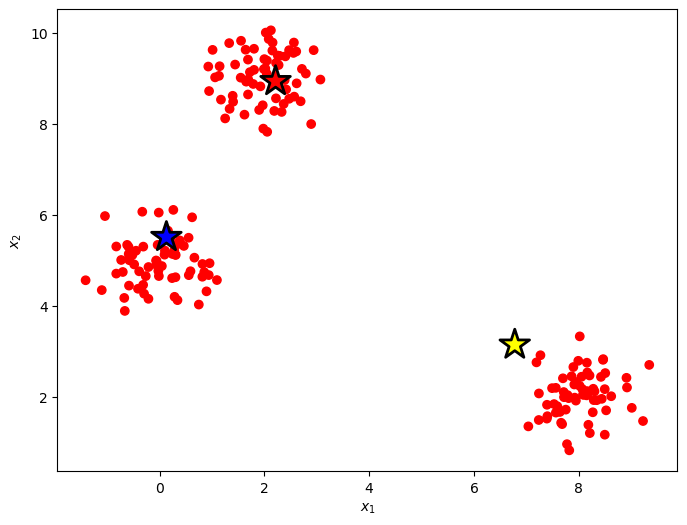

In [22]:
np.random.seed(12345)

# Inicializar k, centroids y c
# Utiliza la función np.random.permutation y escoge los k primeros números 
# como índices de los ejemplos a seleccionar
k = 3
centroids = np.random.permutation(X)[:k]
c = np.zeros(X.shape[0])
# Mostramos
mostrar(X,c, centroids)

In [23]:
test_nb((centroids == [[ 2.2143,8.9422 ], [ 6.7784,3.1424 ], [ 0.13173,  5.5118 ]]).all(), True, 'Inicialización de c incorrecta')
test_nb((c[:10]==[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]).all(), True, 'Inicialización de c incorrecta')

✔️ Test passed.
✔️ Test passed.


Una vez que hemos inicializado las variables necesarias, vamos a crear dos funciones.
1. Una que llamaremos `asigna`, que se encarga de asignar los valores del vector `c`, es decir, establecerá para cada ejemplo su cluster más cercano (los índices de los clústeres serán 0, 1, 2, etc.). 
2. La otra función que llamaremos `actualiza`, será la encargada de calcular la posición de los nuevos centroides, conociendo el nuevo vector `c`.

Crea una función `asigna` a la se le pasen como parámetros los ejemplos y los centroides y devuelva un vector `c` en el que aparezca el cluster más cercano para cada ejemplo, es decir el clúster cuyo centroide este a una distancia Euclidea mínima (sin aplicar la raíz cuadrada).

In [26]:
def asigna(X, centroids):
    """
    Recibe los ejemplos y los centroides y calcula a qué clúster pertenece cada ejemplo
    :param X: Matriz con los ejemplos
    :param centroids: Matriz con un centroide en cada fila
    :return: Vector c con la asignación de cada ejemplo a un clúster (entre 0 y k-1)
    """
    # Solo necesitas hacer un for por los centroides
    c = np.zeros(X.shape[0])
    dist_min = np.full(X.shape[0],np.inf)

    for i,centroid in enumerate(centroids):
        dist = np.sum((X - centroid)**2,axis=1)
        mask = dist < dist_min
        dist_min[mask] = dist[mask]
        c[mask] = i

    return c

Con la inicialización aleatoria que hemos creado antes, comprobamos la función asigna y vemos si los ejemplos se asignan a los clústers debidamente en base a la gráfica.

In [27]:
# Utiliza asigna y luego muestra los resultados
c = asigna(X, centroids)
print(c)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.]


In [28]:
test_nb( (c== [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]).all(), True, 'Asigna incorrecta' )

✔️ Test passed.


Crea una función `actualiza` a la que se le pasen como parámetros los ejemplos, el vector `c` (el vector que muestra el cluster al que está asignado cada ejemplo) y el número de clústeres que estamos buscando y devuelva un vector con los valores de los nuevos centroides.

In [29]:
def actualiza(X, centroids, c, k):
    """
    Recibe los ejemplos, los centroides, el vector c y el número de centroides (k) 
    y recalcula la nueva posición de los centroides
    :param X: Matriz con los ejemplos
    :param centroids: Matriz con los centroides actuales
    :param c: Asignación de los ejemplos a los clústeres
    :param k: Número de clústers
    :return: Nuevos centroides
    """
    for i in range(k):
        centroids[i] = np.mean(X[c==i],axis=0)
        
    return centroids  

Comprobamos la función actualiza. Utilízala para recalcular la posición de los clústers y muestra el resultado.

In [30]:
# Aplica actualiza y muestra los resultados
centroids = actualiza(X, centroids, c, k)
print(centroids)

[[ 1.97705045  9.0467803 ]
 [ 8.00524242  2.05894424]
 [-0.01683136  4.95870606]]


In [31]:
test_nb((np.round(centroids, 4) == [[ 1.9771,  9.0468], [ 8.0052,  2.0589], [-0.0168,  4.9587]]).all(), True, 'Actualiza incorrecta')

✔️ Test passed.


Finalmente vamos a crear una función que calcule el valor de la función objetivo, dados unos ejemplos, unos centroides y un vector de asignaciones. Recuerda que el coste se calcula como la media de las distancias de cada ejemplo a su centroide más cercano. Cuando hablamos de distancia, utilizamos la distancia Euclidea sin la raíz cuadrada. La función de coste es:

$$
J = \sum_{i=1}^n \| x^{(i)} - \mu_{c^{(i)}} \|^2
$$

Donde:

- $n$: Número total de puntos en el dataset.
- $x^{(i)}$: Punto $i$-ésimo del dataset.
- $\mu_{c^{(i)}}$: Centroide del cluster asignado al punto $x^{(i)}$.
- $\| x^{(i)} - \mu_{c^{(i)}} \|^2$: Distancia euclidiana al cuadrado entre el punto $x^{(i)}$ y su centroide correspondiente.



In [ ]:
def coste(X, centroids, c):
    """
    Esta función recibe los ejemplos, los centroides y las asignaciones de cada ejemplo a un clúster (vector c)
    y devuelve el coste asociado a dicho particionamiento.
    :param X: Matriz con los ejemplo
    :param centroids: Matriz con los centroides actuales
    :param c: Asignación de los ejemplos a los clústeres
    :return: Coste de la asignación actual de los ejemplos a los centroides
    """
    J = np.sum((X - centroids[c.astype(int)])**2) / X.shape[0]
    return J

Comprueba que la función coste funciona correctamente con el estado actual del clustering.

In [38]:
cost = coste(X,centroids, c)
print(cost)

0.5498971539915939


In [39]:
test_nb(round(cost, 8), 0.54989715, 'Función de coste incorrecta')

✔️ Test passed.


Finalmente creamos el algoritmo.

In [42]:
# Algoritmo k-means
def kmeans(X, k, it=10):
    """
    Recibe los ejemplos, el valor de k y el número de iteraciones y aplica el algoritmo k-means
    :param X: Matriz con los ejemplos
    :param k: Número de clústers a encontrar
    :param it: Número de iteraciones a realizar (10 por defecto)
    :return: Una tupla (centroids, J, c) con los centroides, un vector J con el 
            error después de cada iteración y el vector c con la asignación de cada ejemplo a un clúster
    """
    # Inicializar centroides aleatoriamente cogiendo los índices de la siguiente forma: np.random.permutation(m)[:k]
    m = X.shape[0]
    centroids = np.random.permutation(X)[:k]
    J = np.zeros(it)
    for i in range(it):
        c = asigna(X, centroids)
        centroids = actualiza(X, centroids, c, k)
        J[i] = coste(X,centroids,c)


    return (centroids, J, c)

Comprueba que el algoritmo funciona. Ejecuta la función `kmeans` y muestra sus resultados y comprueba que el error decrece en cada iteración de k-means.

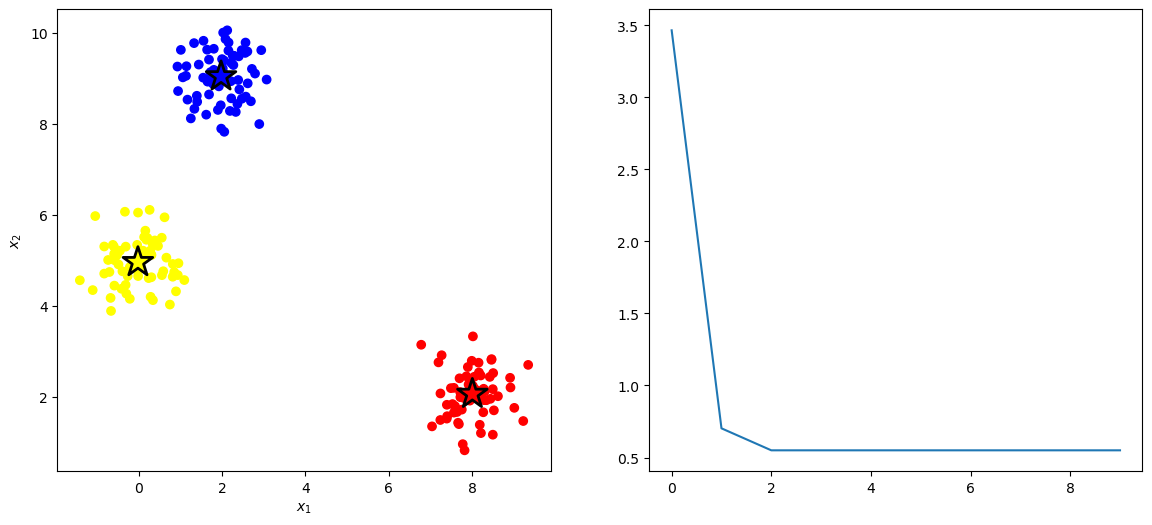

In [47]:
np.random.seed(123524)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Ejecutamos kmeans y mostramos el resultado
k =3
centroids, J, c = kmeans(X, k)

# Dibuja la gráfica del error
mostrar(X,c,centroids, ax[0])
ax[1].plot(np.arange(10),J,label='error')
plt.show()

In [44]:
test_nb((np.round(centroids, 4) == [[ 8.0052,  2.0589], [-0.0168,  4.9587], [ 1.9771,  9.0468]]).all(), True, 'Centroides incorrectos')
test_nb((np.round(J, 4) == [ 3.466 ,  0.7026,  0.5499,  0.5499,  0.5499,  0.5499,  0.5499, 0.5499,  0.5499,  0.5499]).all(), True, 'Errores incorrectos')

✔️ Test passed.
✔️ Test passed.


Ya hemos conseguido que el algoritmo k-means funcione. Ahora debes crear una función que ejecute el algoritmo k-means con 100 inicializaciones aleatorias diferentes (parámetro configurable, por defecto a 100) y devuelva los centroides y el vector `c` de la solución con menor valor de la función objetivo.

In [61]:
def ejecuta_kmeans(X, k, repeticiones=100):
    """
    Recibe los ejemplos, un valor de k y el número de repeticiones a realizar y ejecuta el algortimo kmean
    dicho número de repeticiones y devuelve la partición en la que menor haya sido el error (coste)
    :param X: Matriz con los ejemplos
    :param k: Número de clústeres
    :param repeticiones: Número de repeticiones a realizar (100 por defecto)
    :return: Una tupla (centroids_min, J_min, c_min) con los mejores centroides, el menor error encontrado (un valor) y 
    la asignación de los ejemplos a su clúster
    """
    m = X.shape[0]
    n = X.shape[1]
    centroids_min = np.zeros(shape=(k,n))
    J_min = np.inf
    c_min = np.zeros(m)
    for i in range(repeticiones):
        centroids,J,c = kmeans(X, k)
        if J[-1] < J_min:
            (centroids_min, J_min, c_min) = centroids, J[-1], c

    return (centroids_min, J_min, c_min)

Comprueba que la función creada funciona y muestra su resultado.

In [64]:
np.random.seed(1123123)
centroids, J, c = ejecuta_kmeans(X, k)

In [63]:
test_nb((np.round(centroids, 4) == [[ 8.0052,  2.0589], [-0.0168,  4.9587], [ 1.9771,  9.0468]]).all(), True, 'Centroides incorrectos')

✔️ Test passed.


## Índices de validez y mejor valor de k <a id="indices_validez"></a>

En esta segunda parte de la práctica vamos  programar dos métodos para establecer el mejor valor de k para cada problema.

El primero es la regla del "codo". Para ello debes ejecutar kmeans con diferentes valores de k (entre 2 y 10) y generar una gráfica que te permita observar cuál es el mejor valor de k según el punto donde esté el "codo" de la gráfica. Recuerda que según el problema es posible que dicho "codo" no esté claro.

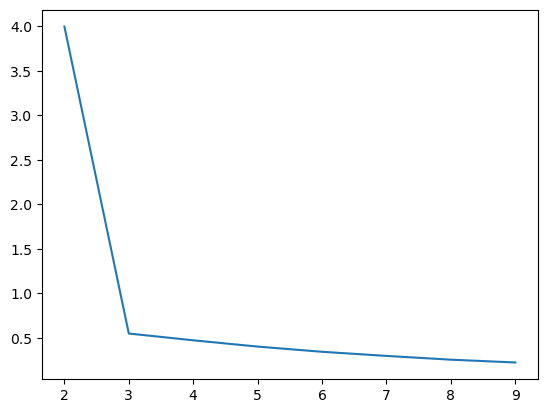

In [68]:
J_all = []
K_all = np.arange(2,10,1)

for k in K_all:
    centroids, J, c = ejecuta_kmeans(X,k)
    J_all.append(J)

# Mostrar gráfica
plt.plot(K_all, J_all)

¿Dónde está el codo? ¿Cuál es el mejor valor de k?

In [66]:
best_k = 3


In [67]:
test_nb(hashlib.sha1(str(best_k).encode('utf-8')).hexdigest(), 
              '77de68daecd823babbb58edb1c8e14d7106e83bb', 
              'Mejor valor de K incorrecto')

✔️ Test passed.


El último paso es programar el índice Davies–Bouldin para comprobar dados unos datos y una partición (vector `c`) cómo de buena es esa partición (y poder compararla frente a otros valores de k).

Crea una función que tenga como parámetros el conjunto de datos, los centroides, el número de clústeres y el vector `c`, y devuelva el valor DB. A continuación, recordamos el cálculo para obtener el índice de Davies-Bouldin.




El **índice Davies-Bouldin** es un método para evaluar la validez de un clustering. Este índice busca que los clusters sean **compactos** y estén **separados entre sí**.

1. **Compacticidad** del cluster $j$:La compacticidad mide qué tan agrupados están los puntos dentro de un cluster. Para el cluster $j$, se calcula como:
     $$
     C_j = \frac{1}{|C_j|} \sum_{x^{(i)} \in C_j} \| x^{(i)} - \mu_j \|^2,
     $$
     donde $|C_j|$ es el número de puntos en el cluster $j$, $x^{(i)}$ representa cada punto en el cluster $C_j$, y $\mu_j$ es el centroide del cluster $j$.

2. **Separación** entre los clusters $i$ y $j$: La separación mide la distancia entre los centroides de dos clusters. Para los clusters $i$ y $j$, se define como:
     $$
     S_{i,j} = \| \mu_i - \mu_j \|^2,
     $$
     donde $\mu_i$ y $\mu_j$ son los centroides de los clusters $i$ y $j$, respectivamente.

3. **Cálculo del peor caso $R_i$**: Para cada cluster $i$, se calcula el "peor caso" comparando la compacticidad de $i$ y $j$ en relación con su separación:
     $$
     R_i = \max_{i \neq j} \frac{C_i + C_j}{S_{i,j}}.
     $$

4. **Índice Davies-Bouldin**: El índice Davies-Bouldin se obtiene como la media de todos los $R_i$:
     $$
     DB = \frac{1}{K} \sum_{i=1}^K R_i,
     $$
     donde $K$ es el número total de clusters.

5. **Selección del $K$ óptimo**: El valor óptimo de $K$ será el que minimice el valor del índice Davies-Bouldin ($DB$). Un menor valor de $DB$ indica clusters más compactos y bien separados.


In [71]:
def davies_bouldin(X, centroids, k, c):
    """
    Establece lo buena que es una partición de los datos
    :param X: Matriz de ejemplos
    :param centroids: Centroides de los clústeres
    :param k: Número de clústeres
    :param c: Asignación de cada ejemplo a un clúster
    :return: índice de Davies-Bouldin
    """
    comp = np.zeros((k))  # Compacticidad
    sep = np.zeros((k, k)) # Separabilidad
    R = np.zeros((k))   # Valor de R
    
    for i in range(k):
        mask = (c == i)
        c_j = mask.sum()
        comp[i] = np.sum((X[mask] - centroids[i])**2) / c_j

    for i in range(k):
        for j in range(k):
            if i != j:
                sep[i,j] = np.sum((centroids[i] - centroids[j])**2)
            else:
                sep[i,j] = -1
    
    vals = []
    for i in range(k):
        for j in range(k):
            numerador = comp[i] + comp[j]
            denominador = sep[i,j]
            vals.append(numerador / denominador)
        R[i] = np.max(vals)
        vals = []

    # Realiza los cálculos en tres pasos:
        # 1. Calcula la compacticidad de cada clúster
        # 2. Calcula la separabilidad entre cada par de clústeres
        # 3. Calcula el peor caso R para cada clústes
        # 4. Devuelve el índice de Davies-Bouldin como la media de los R de todos los clústeres
    return R.mean()


A continuación crea una función que haciendo uso de la función `best_k_DB` permita obtener el mejor valor de k. 

Para ello, la función recibirá los ejemplos y el rango en el que queremos buscar $k \in [a, b)$. Para cada valor de k obtendrá la mejor partición de kmeans y calculará su índice de Davies-Bouldin. Finalmente, devolverá un vector con los valores de k probados, otro con los valores de Davies-Bouldin obtenidos y el mejor valor de k para dichos datos (aquel que obtenga el menor valor del índice de  Davies-Bouldin). 

In [74]:
def best_k_DB(X, a=2, b=10):
    """
    Esta función busca el mejor valor de k entre a y b para un conjunto de datos dado en base al índice de Davies-Bouldin
    :param X: Matriz de ejemplos
    :param a: Mínimo valor de k
    :param b: Máximo valor de k (no inclusivo)
    :return: Tupla (K_all, DB_all, best_k) con los valores de k probados, los valores de DB y el mejor valor de K
    """ 
    k_vals = np.arange(a,b,1)
    DB_vals = []
    DB_best = np.inf
    best_k = -1

    for k in (k_vals):
        centroids, J, c = ejecuta_kmeans(X, k)
        DB = davies_bouldin(X,centroids, k, c)
        DB_vals.append(DB)
        if DB < DB_best:
            DB_best = DB
            best_k = k
    
    return k_vals, DB_vals, best_k
    

Comprobamos ahora utilizando la función anterior que para para el conjunto de datos, el valor de mínimo de DB (para `k=2, 3, 4, .., 9`) coincide con el número de clústeres que hay realmente en el conjunto de datos. Dibujaremos también una gráfica que muestre para cada valor de k probado su índice de DB.

/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


best k: 3


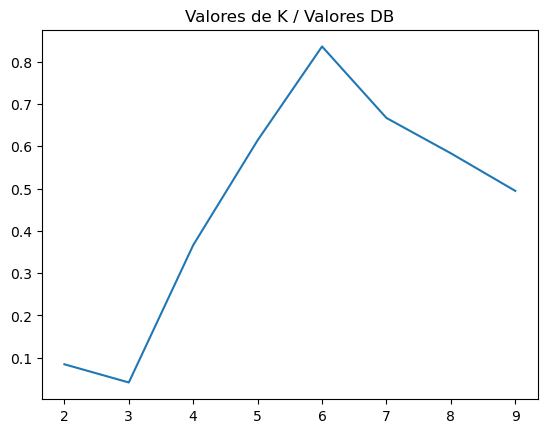

In [81]:
k_vals, db_vals, best_k = best_k_DB(X)
print(f"best k: {best_k}")

plt.plot(K_vals, db_vals)
plt.title('Valores de K / Valores DB')
plt.show()


In [77]:
test_nb(hashlib.sha1(str(best_k).encode('utf-8')).hexdigest(),
                        '77de68daecd823babbb58edb1c8e14d7106e83bb', 
                        'Mejor valor de K incorrecto')

✔️ Test passed.


## Estudio para diferentes problemas
Finalmente vamos a realizar un estudio más completo que nos permita establecer para todos los ficheros de datos facilitados en la práctica (desde `ex2k.txt` hasta `ex8K.txt`) cuál es el mejor número de clústers para cada problema. Puedes comprobar si estás de acuerdo acompañando la gráfica de los valores probados de k y el valor de DB con otra gráfica que muestre el problema y los clústeres encontrados. Las gráficas que debes mostrar deben ser similares a la mostrada en la siguiente figura.

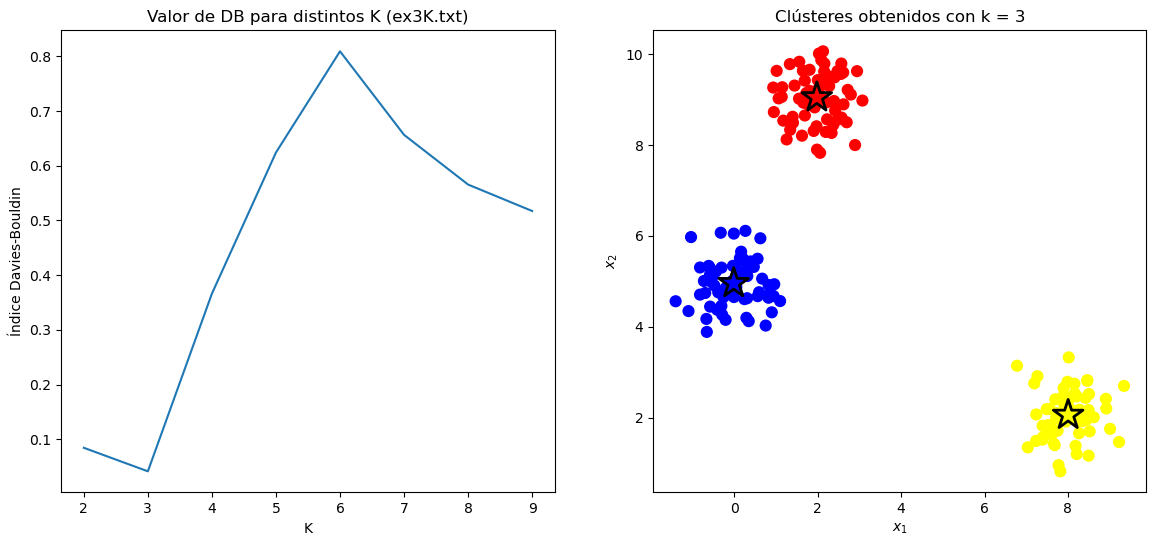

/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


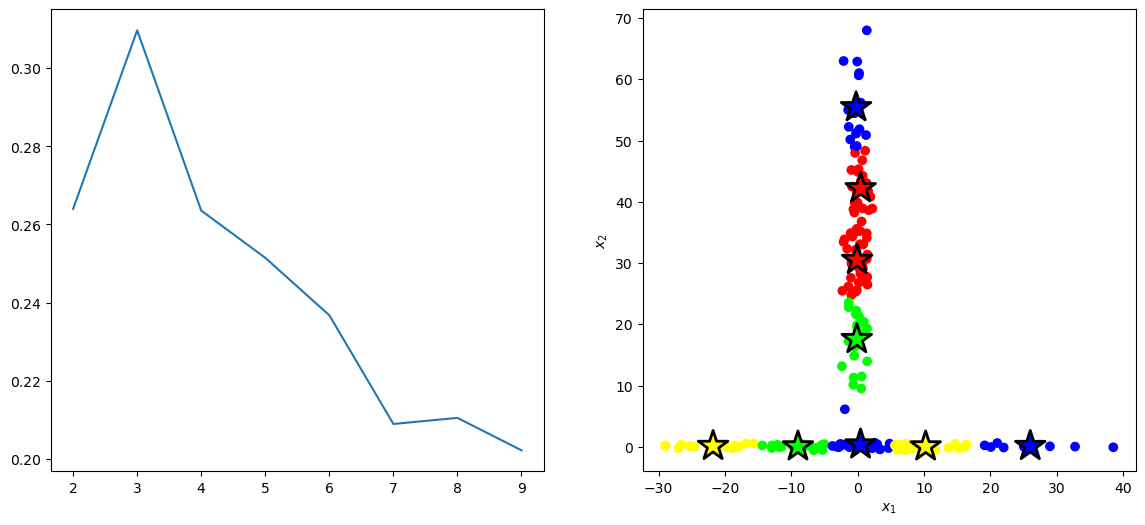

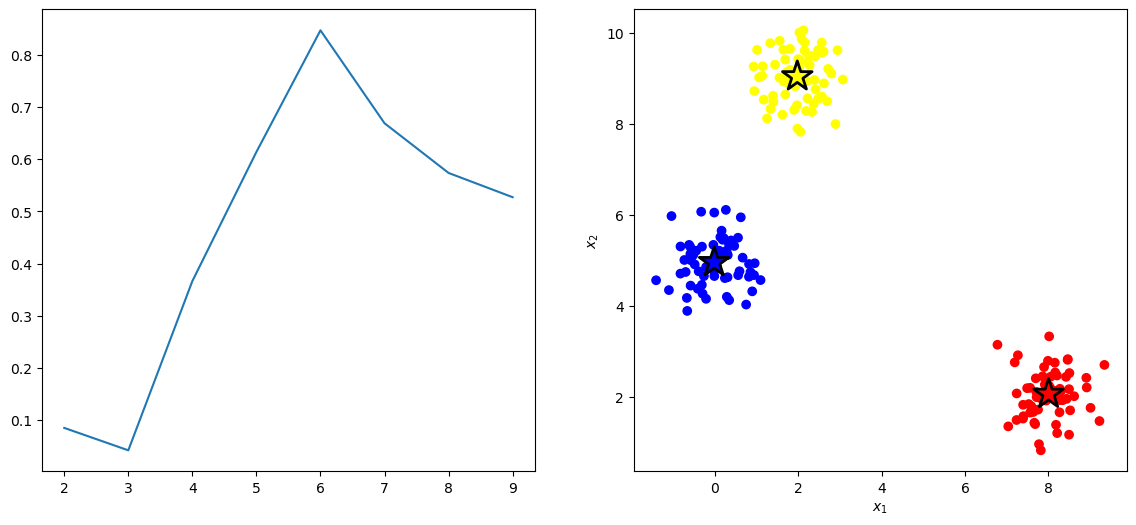

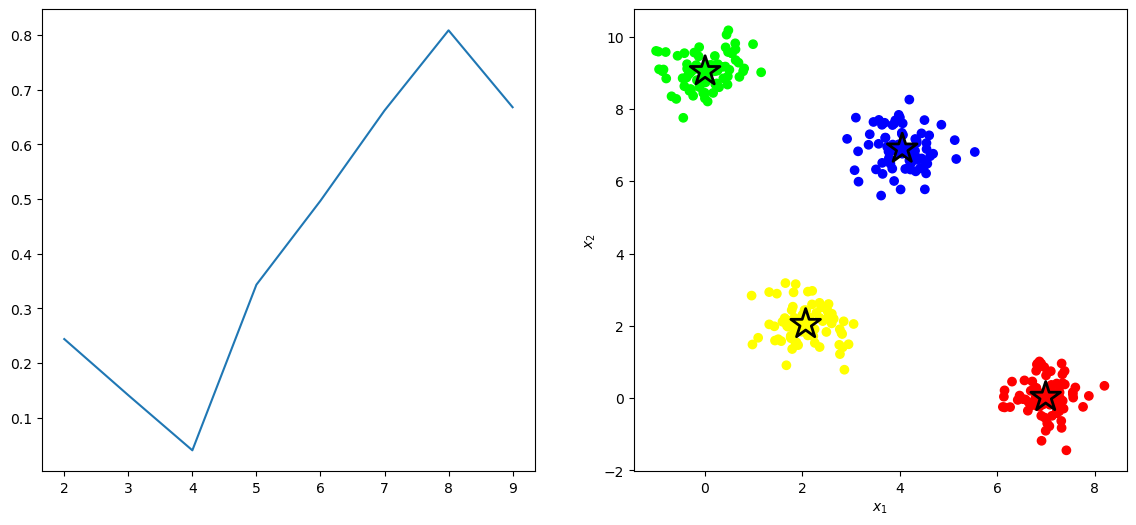

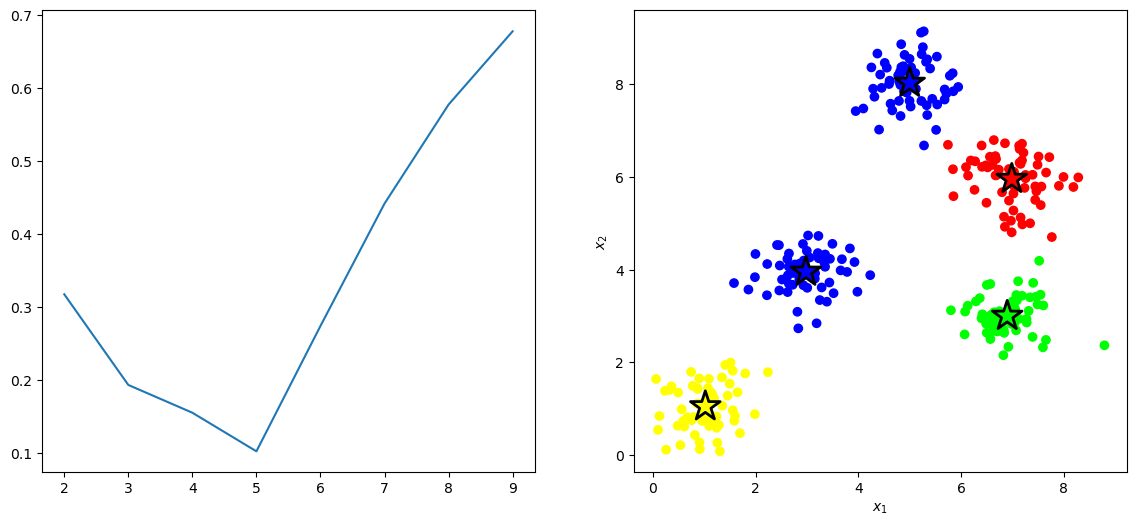

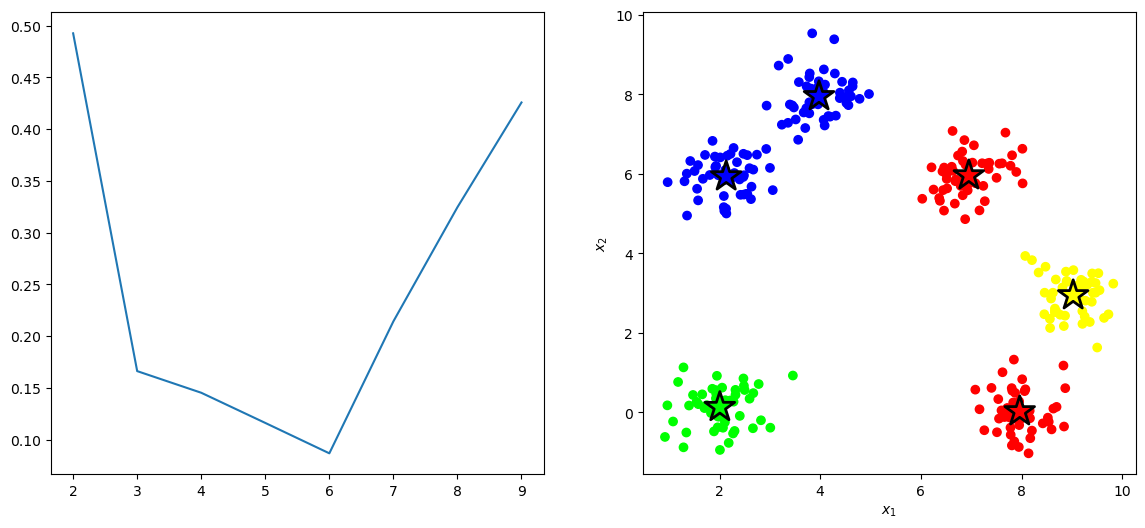

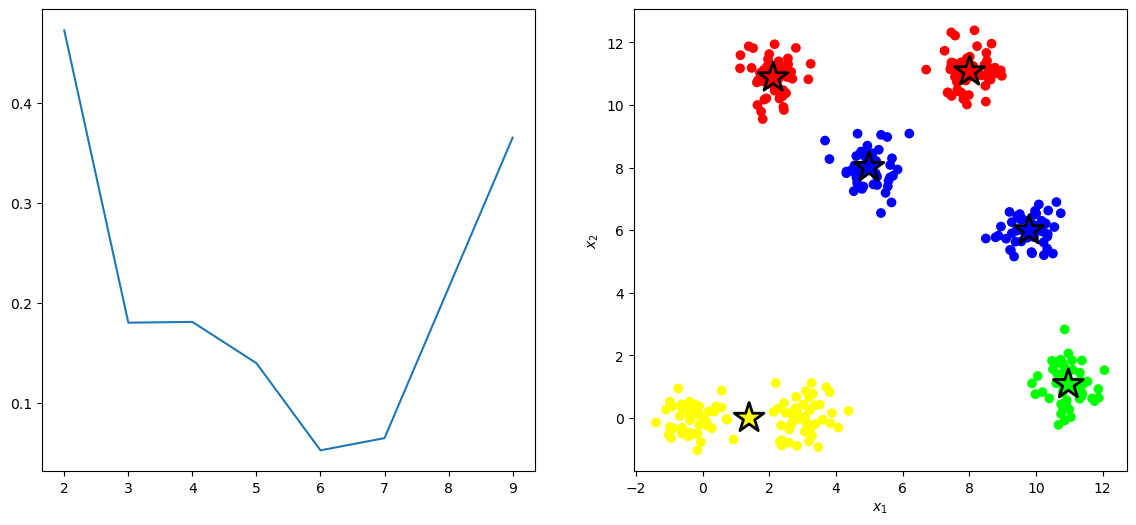

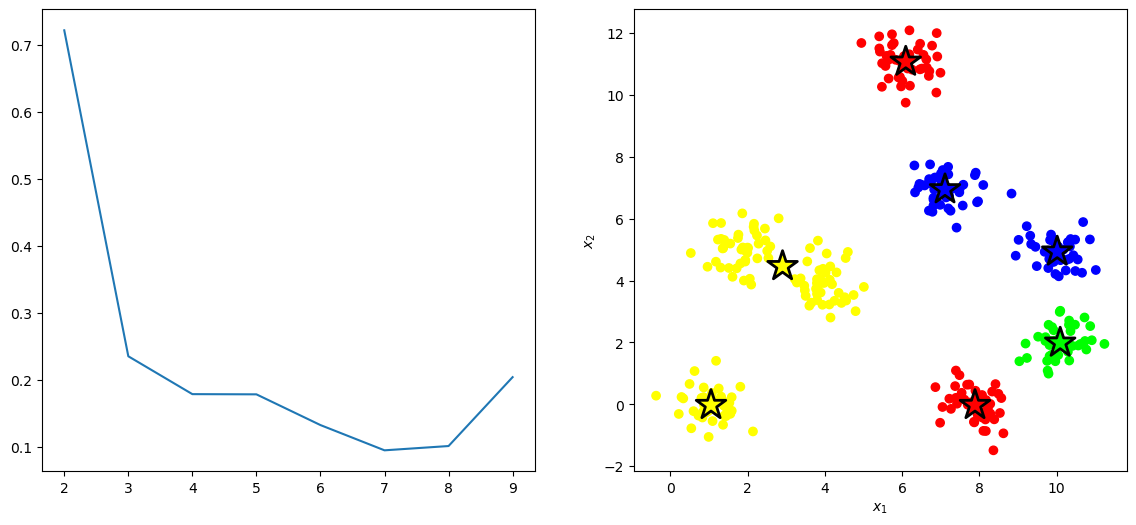

In [86]:
files = range(2, 9)

for f in files: 

    # Lee los datos del fichero correspondiente y obtén el mejor valor de k
    X = np.loadtxt(f'datasets/ex{f}k.txt', delimiter=',')

    # Crear una figura con dos subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Realiza una primera gráfica en ax[0] donde muestres los valores de DB obtenidos para cada k
    k_vals, db_vals, best_k = best_k_DB(X)
    ax[0].plot(k_vals, db_vals)
    
    # Realiza una segunda gráfica en ax[1] con el resultado del clustering del mejor k
    centroids, J, c = ejecuta_kmeans(X, best_k)
    mostrar(X,c,centroids, ax[1])
    
    # Mostrar la figura con ambos subplots
    plt.show()


¿Ves algo raro? ¿Funciona siempre bien el índice de Davies-Bouldin? Estudia qué pasa en los casos en los que el resultado te llame la atención

ESCRIBE TU RESPUESTA

## K-means en scikit-learn <a id="sklearn"></a>

Modifica ahora el código anterior para replicar el ejercicio utilizando scikit-learn. Debes hacer uso de [KMeans](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html) y [`davies_biulding_score`](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.davies_bouldin_score.html). Tendrás que hacer una copia y modificar la función `best_k_DB` para que haga uso de las funciones de scikit-learn.

In [87]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score


def best_k_DB(X, a=2, b=10):
    """
    Esta función busca el mejor valor de k entre a y b para un conjunto de datos dado en base al índice de Davies-Bouldin
    :param X: Matriz de ejemplos
    :param a: Mínimo valor de k
    :param b: Máximo valor de k (no inclusivo)
    :return: Tupla (K_all, DB_all, best_k) con los valores de k probados, los valores de DB y el mejor valor de K
    """    
    # <RELLENAR>
    K_all = []
    DB_all = []
    best_DB = np.inf
    best_k = -1

    for k in range(a, b):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        c = kmeans.labels_
        DB = davies_bouldin_score(X, c)
        
        K_all.append(k)
        DB_all.append(DB)
        
        if best_DB > DB:
            best_DB = DB
            best_k = k
    
    return K_all, DB_all, best_k
    

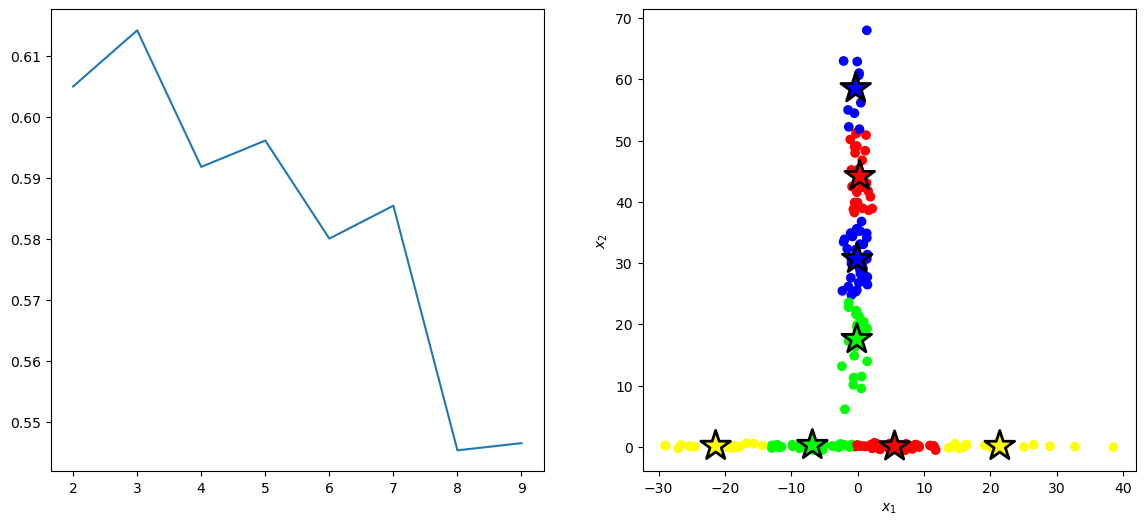

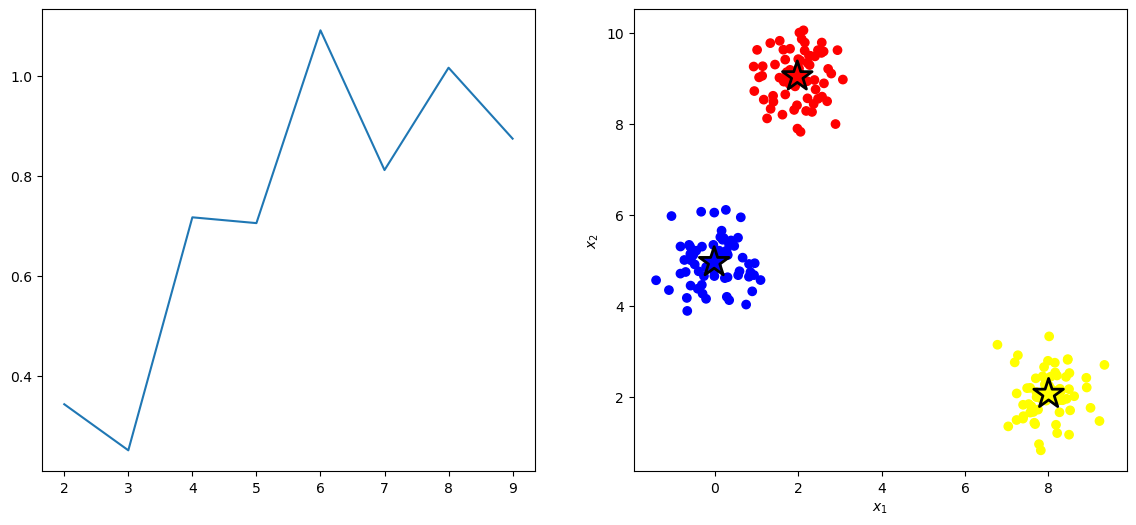

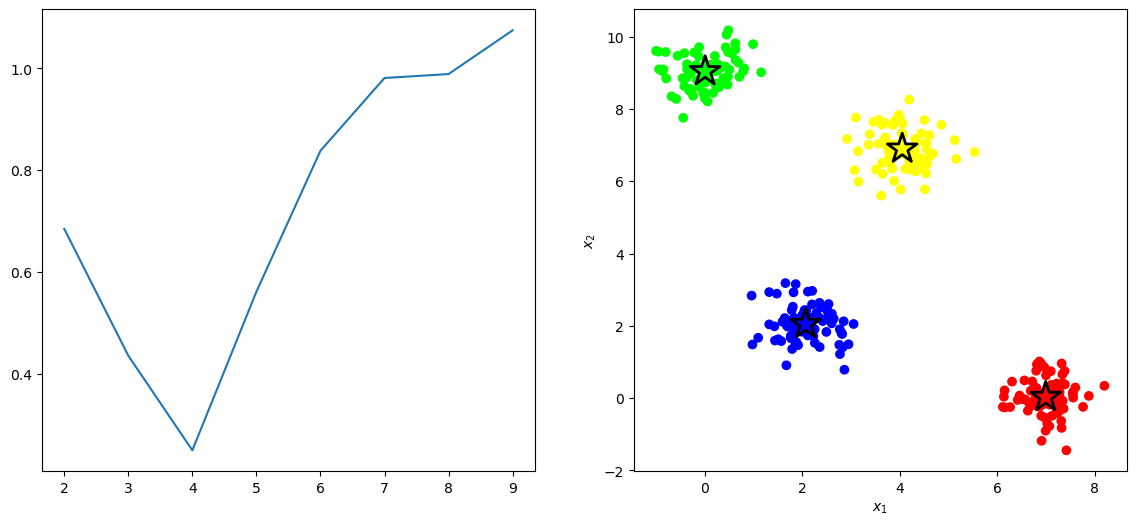

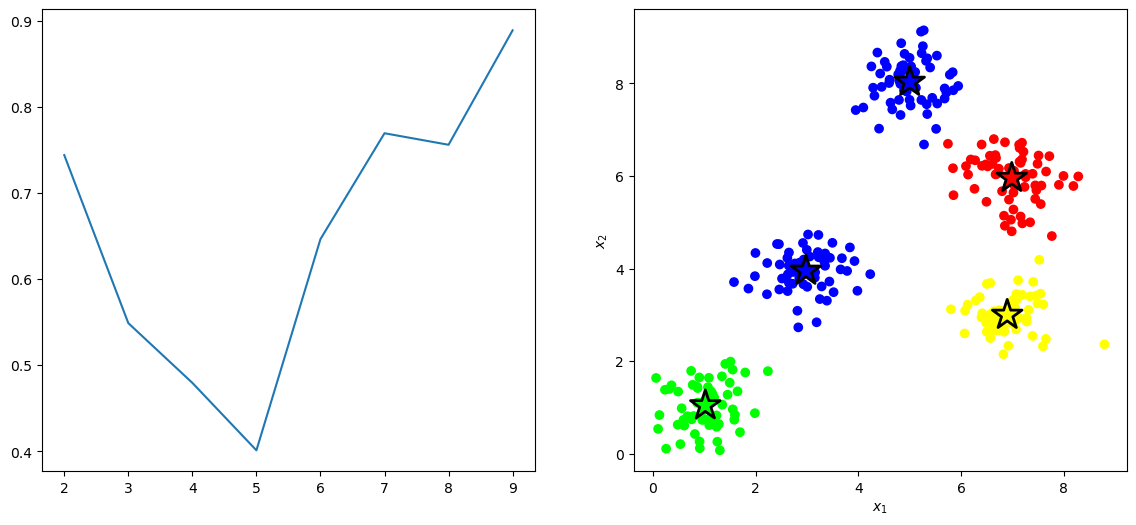

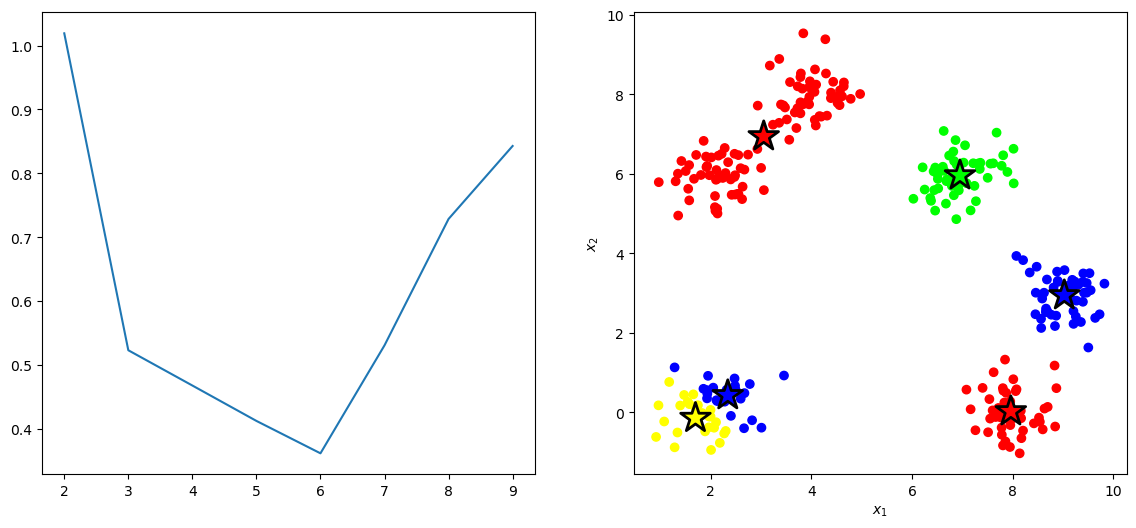

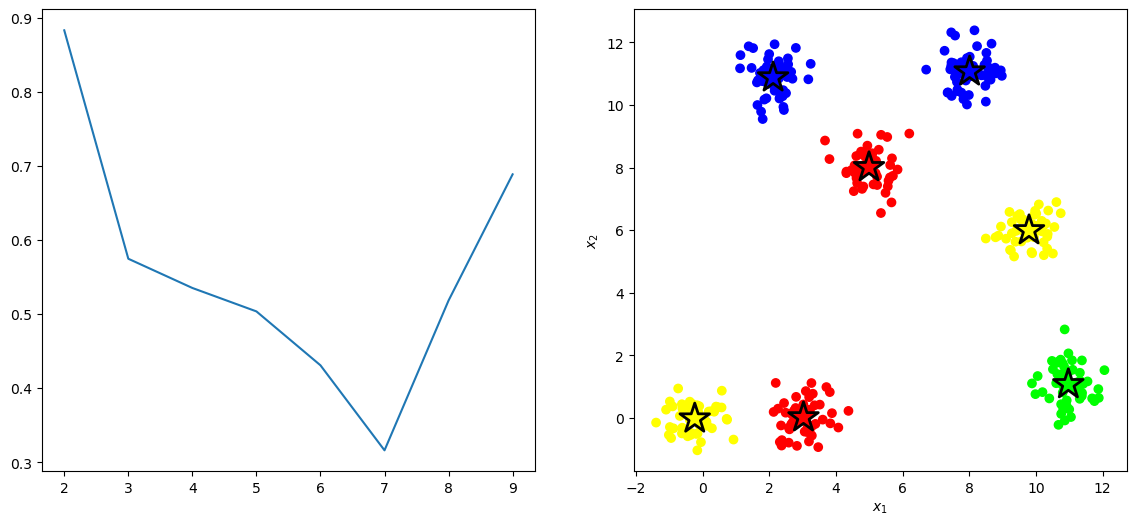

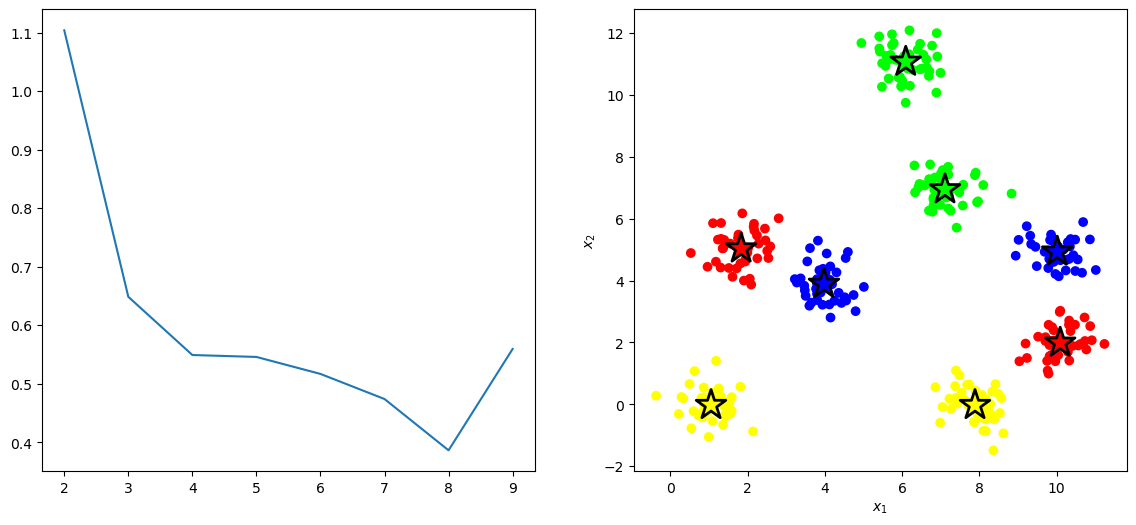

In [88]:
files = range(2, 9)

for f in files: 

    # Lee los datos del fichero correspondiente y obtén el mejor valor de k
    X = np.loadtxt(f"datasets/ex{f}K.txt", delimiter=",")
    K_all, DB_all, best_k = best_k_DB(X)

    # Crear una figura con dos subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Realiza una primera gráfica en ax[0] donde muestres los valores de DB obtenidos para cada k
    ax[0].plot(K_all, DB_all)

    # Realiza una segunda gráfica en ax[1] con el resultado del clustering del mejor k
    kmeans = KMeans(best_k)
    kmeans.fit(X)
    c = kmeans.labels_
    centroids = kmeans.cluster_centers_
    mostrar(X, c, centroids, ax[1])

    # Mostrar la figura con ambos subplots
    plt.show()

## Parte opcional <a id="opcional"></a>

Los ejercicios anteriores permiten, si se completan perfectamente, alcanzar un 8 en esta práctica (notable). Esta última parte se valora 2 puntos, permitiendo alcanzar el 10 (sobresaliente).

### Clustering jerárquico en Python [Opcional] <a id="clustering_jerarquico"></a>

¿Y si queremos utilizar el clustering jerárquico en vez del kmeans tradicional?

Realiza las investigaciones necesarias para implementar el clustering jerárquico y aplicarlo a los problemas anteriores. Trata también de dibujar el dendograma resultante. Aquí debajo tienes algunos enlaces que te pueden ayudar:

* Opciones con scikit-learn:
    * [Hierarchical clustering - explicación](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)
    * [Agglomerative clustering - implementación](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
* Opciones con scipy:
    * [Linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)
    * [Paquete hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html)


Puedes tratar de replicar las últimas figuras añadiendo el dendograma obtenido.

In [ ]:
# <RELLENAR>

In [ ]:
# <RELLENAR>

### Comparativa con K-means en scikit [Opcional] <a id="sklearn_opcional"></a>
Intenta comparar el método de K-means con otros métodos de clustering jerárquico disponibles en scikit.

In [ ]:
# <RELLENAR>

### Otros datos [Opcional] <a id="otros_datos"></a>
Puedes repetir la ejecución anterior con otros datos sintéticos creados con los métodos de scikit que te permitan ver cómo se comporta kmeans en los diferentes casos. [Generador de problemas sintéticos de scikit-learn](http://scikit-learn.org/stable/modules/classes.html#samples-generator).

In [ ]:
# <RELLENAR>